In [1]:
from binance.client import Client
import os
import json
from binance import ThreadedWebsocketManager
import numpy as np
import pandas as pd
from talib.abstract import STOCH

In [2]:
with open('../config/key.json') as j:
    keys = json.load(j)

In [3]:
client = Client(keys['api_key'], keys['api_secret'])
dict_data = {'error':False}
bsm = ThreadedWebsocketManager()

In [ ]:
STOCH()

In [ ]:
data = {
    "price_buy":[],
    "price_sell":[],
    "p_open":0,
    "status":True,
    "sell":0,
    "sw":False,
    "first":True,
    "symbol":"ETHBUSD",
    "starttime": "30 day ago UTC",
    "interval":"1m",
    "low_span":100,
    "hight_span":200
}

print('init get data')
bars = client.get_historical_klines(data["symbol"], data["interval"], data["starttime"])
bars = [line[4] for line in bars]
df = pd.DataFrame(bars, columns=['close'])
print('finish get data')
plot_low = []
plot_hight = []

def btc_trade_history(msg):
    global data,bsm,df

    if data['status'] != True:
        bsm.stop()
        
    if msg['e'] != 'error':
#         calculate
        if data['first']:
            data['first'] = False
            data['p_open'] = msg['k']['o']
            print('p_open:',data['p_open'])
        else:
            if float(msg['k']['o']) != float(data['p_open']):
                # state change 
                print('state change:',data['p_open'])
                df = df.iloc[1: , :]
                df2 = pd.DataFrame([msg['k']["o"]],columns=['close'])
                df = pd.concat([df, df2], ignore_index = True, axis = 0)
                
        if float(msg['k']['o']) != float(data['p_open']) or data['first']:
            # calculate EMA100 and EMA200
            low_df = cal_EMA(df,data['low_span'])
            hight_df = cal_EMA(df,data['hight_span'])
            sORb = buyORsell(low_df, hight_df)

            # sell
            if data['sw']:
                # check price sell>buy
                if sORb:
                    if float(msg['k']['o']) > float(data["price_buy"][-1]):
                        # order_sell = client.order_market_sell(symbol=data['symbol'],quantity=round(float(sell_price),4))
                        # print('order_sell:',order_sell)
                        data["price_sell"].append(msg['k']['o'])
                        # save price sell
                        data['price'] = msg['k']['o']
                        print('sell:',data['price'])
                        # change status sw to False
                        data['sw'] = False
            # buy
            else:
                if not sORb:
                    # order_buy = client.order_market_buy(symbol=data['symbol'],quantity=buy_coin)
                    data["price_buy"].append(msg['k']['o'])
                    print('buy:',msg['k']['o'])
                    # data["price"] = float(msg['k']['c'])
                    data['sw'] = True
                    
            # change value
            data['p_open'] = msg['k']['o']
            print('changed:',data['p_open'])
                    
        dict_data['error'] = False
    else:
        dict_data['error'] = True

In [2]:
import yfinance as yf
from talib.abstract import STOCH,STOCHF,STOCHRSI
import matplotlib.pyplot as plt

In [3]:
data = yf.download("AAPL", start="2020-05-10", end="2022-09-10")

[*********************100%***********************]  1 of 1 completed


## SHOCHASTIC SLOW

In [4]:
slowk, slowd = STOCH(data['High'], data['Low'], data['Close'])

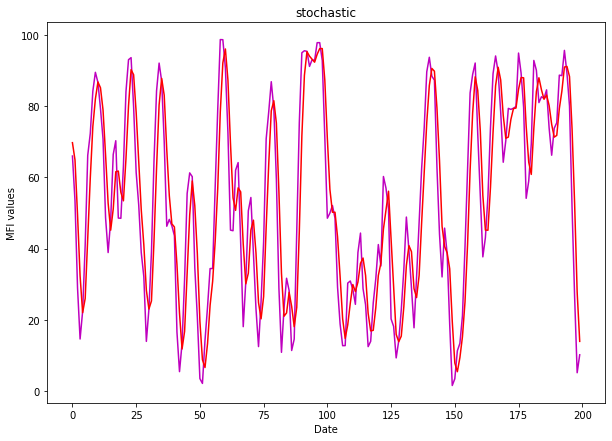

In [5]:
fig = plt.figure(figsize=(10, 7))
plt.title('stochastic')
plt.xlabel('Date')
plt.ylabel('MFI values')

plt.plot(slowk[-200:], 'm', label='slowk')
plt.plot(slowd[-200:], 'r', label='slowd')

## SHOCHASTIC FAST

In [10]:
fk, fd = STOCHF(data['High'], data['Low'], data['Close'])

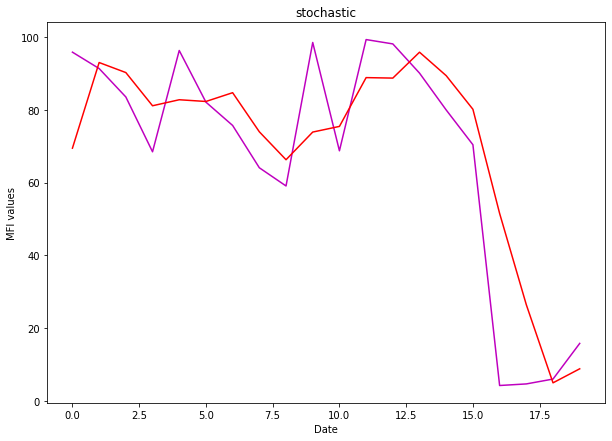

In [12]:
fig = plt.figure(figsize=(10, 7))
plt.title('stochastic')
plt.xlabel('Date')
plt.ylabel('MFI values')

plt.plot(fk[-20:], 'm', label='fastk')
plt.plot(fd[-20:], 'r', label='fastd')

## SHOCHASTIC RSI

In [15]:
rsik, rsid = STOCHRSI(data['Close'])

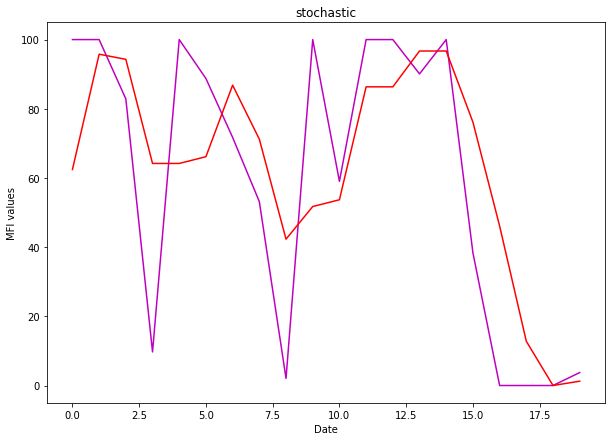

In [16]:
fig = plt.figure(figsize=(10, 7))
plt.title('stochastic')
plt.xlabel('Date')
plt.ylabel('MFI values')

plt.plot(rsik[-20:], 'm', label='rsik')
plt.plot(rsid[-20:], 'r', label='rsid')